# XGBoost para Clasificación de Caracteres

Este notebook implementa un clasificador **XGBoost** para el dataset EMNIST con 62 clases (0-9, A-Z, a-z).

**Objetivo**: Entrenar y evaluar un modelo XGBoost usando datos preprocesados con PCA, comparando su rendimiento con el modelo baseline de regresión logística.

## 1. Importación de Librerías

In [4]:
# Instalar las librerías necesarias directamente desde el notebook
%pip install matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import xgboost as xgb
import pickle
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print('✓ Librerías importadas correctamente')
print(f'✓ Versión de XGBoost: {xgb.__version__}')

✓ Librerías importadas correctamente
✓ Versión de XGBoost: 3.1.2


## 2. Carga de Datos

Cargamos los datos preprocesados que ya tienen PCA aplicado.

In [6]:
# Cargar datos de entrenamiento (con PCA)
print('Cargando datos de entrenamiento...')
train_data = np.load('../../preprocesamiento/output/emnist_train_reduced.npz')
X_train = train_data['X_train']
y_train = train_data['y_train']

# Cargar datos de test (con PCA)
print('Cargando datos de test...')
test_data = np.load('../../preprocesamiento/output/emnist_test_reduced.npz')
X_test = test_data['X_test']
y_test = test_data['y_test']

# Cargar mapeo de clases
print('Cargando mapeo de clases...')
with open('../../preprocesamiento/class_mapping.pkl', 'rb') as f:
    class_mapping = pickle.load(f)

print(f'\n{"="*60}')
print('INFORMACIÓN DEL DATASET')
print(f'{"="*60}')
print(f'Train: {X_train.shape[0]:,} muestras × {X_train.shape[1]} features')
print(f'Test:  {X_test.shape[0]:,} muestras × {X_test.shape[1]} features')
print(f'Clases: {len(np.unique(y_train))} (dígitos + letras mayúsculas + minúsculas)')
print(f'Distribución de clases: {np.bincount(y_train).shape[0]} clases únicas')
print(f'{"="*60}')

Cargando datos de entrenamiento...
Cargando datos de test...
Cargando mapeo de clases...

INFORMACIÓN DEL DATASET
Train: 697,932 muestras × 61 features
Test:  116,323 muestras × 61 features
Clases: 62 (dígitos + letras mayúsculas + minúsculas)
Distribución de clases: 62 clases únicas


## 3. Entrenamiento del Modelo XGBoost

### XGBoost para Clasificación Multiclase

**Justificación del modelo**:
- **Alto rendimiento**: XGBoost es conocido por su excelente rendimiento en competencias de machine learning
- **Manejo de relaciones no lineales**: Captura patrones complejos que modelos lineales pueden perder
- **Regularización incorporada**: Previene overfitting mediante parámetros de regularización L1 y L2
- **Manejo de datos missing**: Robustez ante datos imperfectos
- **Importancia de features**: Proporciona insights sobre qué features son más relevantes

**Parámetros seleccionados**:
- `objective='multi:softprob'`: Para clasificación multiclase con probabilidades
- `num_class=62`: Número de clases en nuestro problema
- `max_depth=6`: Profundidad balanceada para capturar complejidad sin overfitting
- `learning_rate=0.1`: Tasa de aprendizaje estándar para convergencia estable
- `n_estimators=500`: Número suficiente de árboles
- `subsample=0.8`: Muestreo de filas para mayor robustez
- `colsample_bytree=0.8`: Muestreo de columnas para diversidad
- `reg_lambda=1`: Regularización L2
- `random_state=42`: Reproducibilidad

In [7]:
# Crear modelo XGBoost
print(f'\n{"="*60}')
print('ENTRENAMIENTO DEL MODELO XGBOOST')
print(f'{"="*60}')

model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=62,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    early_stopping_rounds=20
)

# Entrenar modelo con validation set para early stopping
print('\nIniciando entrenamiento con early stopping...\n')
start_time = time.time()

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50  # Mostrar progreso cada 50 iteraciones
)

training_time = time.time() - start_time

print(f'\n{"="*60}')
print('✓ ENTRENAMIENTO COMPLETADO')
print(f'{"="*60}')
print(f'Tiempo de entrenamiento: {training_time:.2f} segundos ({training_time/60:.2f} minutos)')
print(f'Número de clases: {len(model.classes_)}')
print(f'Número de árboles utilizados: {model.n_estimators}')
print(f'Mejor iteración: {model.best_iteration if hasattr(model, "best_iteration") else model.n_estimators}')
print(f'{"="*60}')


ENTRENAMIENTO DEL MODELO XGBOOST

Iniciando entrenamiento con early stopping...

[0]	validation_0-mlogloss:2.60655
[50]	validation_0-mlogloss:0.65287
[100]	validation_0-mlogloss:0.55270
[150]	validation_0-mlogloss:0.51951
[200]	validation_0-mlogloss:0.50333
[250]	validation_0-mlogloss:0.49362
[300]	validation_0-mlogloss:0.48765
[350]	validation_0-mlogloss:0.48378
[400]	validation_0-mlogloss:0.48147
[450]	validation_0-mlogloss:0.48056
[483]	validation_0-mlogloss:0.48049

✓ ENTRENAMIENTO COMPLETADO
Tiempo de entrenamiento: 2113.21 segundos (35.22 minutos)
Número de clases: 62
Número de árboles utilizados: 500
Mejor iteración: 463


## 4. Evaluación del Modelo

### 4.1 Métricas Globales

In [8]:
# Predicciones
print('Generando predicciones...\n')
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular métricas para train
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)

# Calcular métricas para test
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

# Mostrar resultados
print(f'{"="*60}')
print('MÉTRICAS DE EVALUACIÓN - XGBOOST')
print(f'{"="*60}')
print(f'\n{"CONJUNTO DE ENTRENAMIENTO":^60}')
print(f'{"":-^60}')
print(f'Accuracy:  {train_accuracy:.4f} ({train_accuracy*100:.2f}%)')
print(f'Precision: {train_precision:.4f}')
print(f'Recall:    {train_recall:.4f}')
print(f'F1-Score:  {train_f1:.4f}')

print(f'\n{"CONJUNTO DE TEST":^60}')
print(f'{"":-^60}')
print(f'Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')
print(f'Precision: {test_precision:.4f}')
print(f'Recall:    {test_recall:.4f}')
print(f'F1-Score:  {test_f1:.4f}')

# Análisis de generalización
diff_accuracy = abs(train_accuracy - test_accuracy)
print(f'\n{"ANÁLISIS DE GENERALIZACIÓN":^60}')
print(f'{"":-^60}')
print(f'Diferencia de accuracy: {diff_accuracy:.4f} ({diff_accuracy*100:.2f}%)')

if diff_accuracy < 0.02:
    print('✓ Excelente generalización')
elif diff_accuracy < 0.05:
    print('✓ Buena generalización')
else:
    print('⚠ Posible overfitting')

print(f'{"="*60}')

Generando predicciones...

MÉTRICAS DE EVALUACIÓN - XGBOOST

                 CONJUNTO DE ENTRENAMIENTO                  
------------------------------------------------------------
Accuracy:  0.9555 (95.55%)
Precision: 0.9580
Recall:    0.9555
F1-Score:  0.9533

                      CONJUNTO DE TEST                      
------------------------------------------------------------
Accuracy:  0.8334 (83.34%)
Precision: 0.8182
Recall:    0.8334
F1-Score:  0.8194

                 ANÁLISIS DE GENERALIZACIÓN                 
------------------------------------------------------------
Diferencia de accuracy: 0.1222 (12.22%)
⚠ Posible overfitting


### 4.2 Curva de Aprendizaje

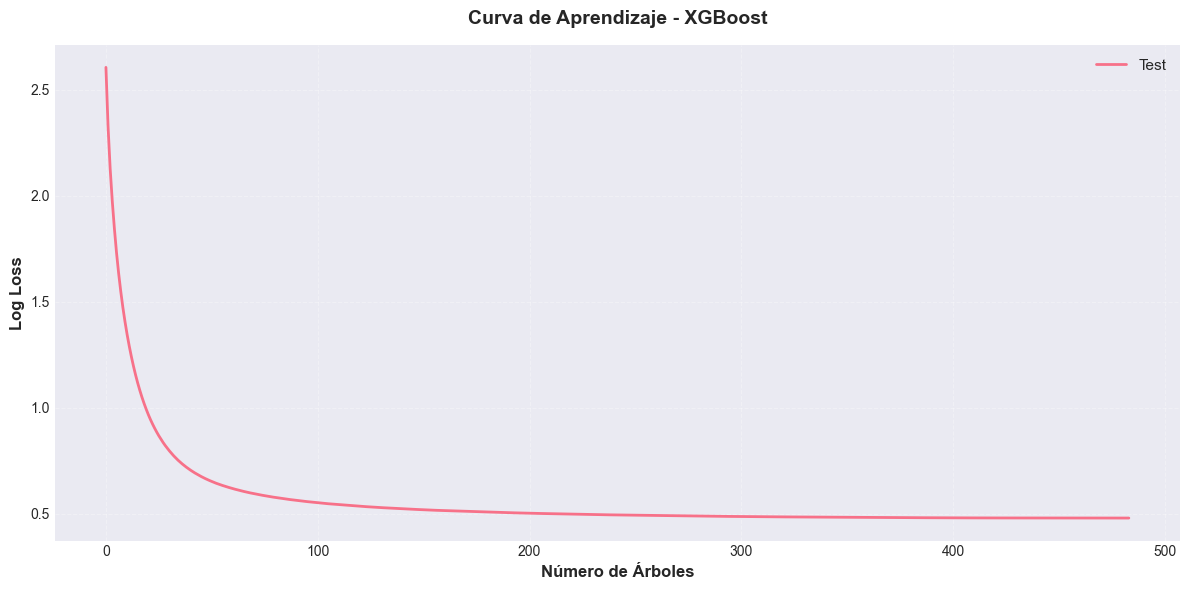

Log Loss final en test: 0.4805


In [9]:
# Obtener resultados de evaluación durante el entrenamiento
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

# Graficar curva de aprendizaje
plt.figure(figsize=(12, 6))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Test', linewidth=2)
plt.xlabel('Número de Árboles', fontsize=12, weight='bold')
plt.ylabel('Log Loss', fontsize=12, weight='bold')
plt.title('Curva de Aprendizaje - XGBoost', fontsize=14, weight='bold', pad=15)
plt.legend(fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Mostrar métricas finales de la curva
final_train_loss = results['validation_0']['mlogloss'][-1]
print(f'Log Loss final en test: {final_train_loss:.4f}')

### 4.3 Reporte de Clasificación por Clase

In [10]:
# Generar reporte de clasificación
target_names = [class_mapping[i] for i in sorted(class_mapping.keys())]

print(f'{"="*80}')
print('REPORTE DE CLASIFICACIÓN DETALLADO (Test Set)')
print(f'{"="*80}\n')

report = classification_report(y_test, y_test_pred, target_names=target_names, zero_division=0)
print(report)

# Convertir a DataFrame para análisis
report_dict = classification_report(
    y_test, y_test_pred, 
    target_names=target_names, 
    output_dict=True,
    zero_division=0
)
report_df = pd.DataFrame(report_dict).transpose()

# Clases con mejor rendimiento
print(f'\n{"="*80}')
print('TOP 10 CLASES CON MEJOR F1-SCORE')
print(f'{"="*80}')
best_classes = report_df.iloc[:-3].sort_values('f1-score', ascending=False).head(10)
print(best_classes[['precision', 'recall', 'f1-score', 'support']].round(4).to_string())

# Clases con peor rendimiento
print(f'\n{"="*80}')
print('TOP 10 CLASES CON PEOR F1-SCORE')
print(f'{"="*80}')
worst_classes = report_df.iloc[:-3].sort_values('f1-score', ascending=True).head(10)
print(worst_classes[['precision', 'recall', 'f1-score', 'support']].round(4).to_string())

# Análisis de clases problemáticas
print(f'\n{"="*80}')
print('ANÁLISIS DE CLASES PROBLEMÁTICAS')
print(f'{"="*80}')
problematic_classes = worst_classes[worst_classes['f1-score'] < 0.7]
if len(problematic_classes) > 0:
    print("Clases con F1-Score < 0.7:")
    for idx, row in problematic_classes.iterrows():
        print(f"  {idx}: F1-Score = {row['f1-score']:.4f}")
else:
    print("✓ Todas las clases tienen F1-Score ≥ 0.7")

REPORTE DE CLASIFICACIÓN DETALLADO (Test Set)

              precision    recall  f1-score   support

           0       0.66      0.79      0.72      5778
           1       0.67      0.89      0.77      6330
           2       0.91      0.96      0.93      5869
           3       0.97      0.97      0.97      5969
           4       0.93      0.95      0.94      5619
           5       0.88      0.89      0.89      5190
           6       0.94      0.97      0.95      5705
           7       0.97      0.98      0.98      6139
           8       0.94      0.96      0.95      5633
           9       0.91      0.97      0.94      5686
           A       0.88      0.91      0.89      1062
           B       0.86      0.80      0.83       648
           C       0.74      0.87      0.80      1739
           D       0.86      0.82      0.84       779
           E       0.94      0.88      0.91       851
           F       0.75      0.86      0.80      1440
           G       0.88      0.78 

### 4.4 Matriz de Confusión

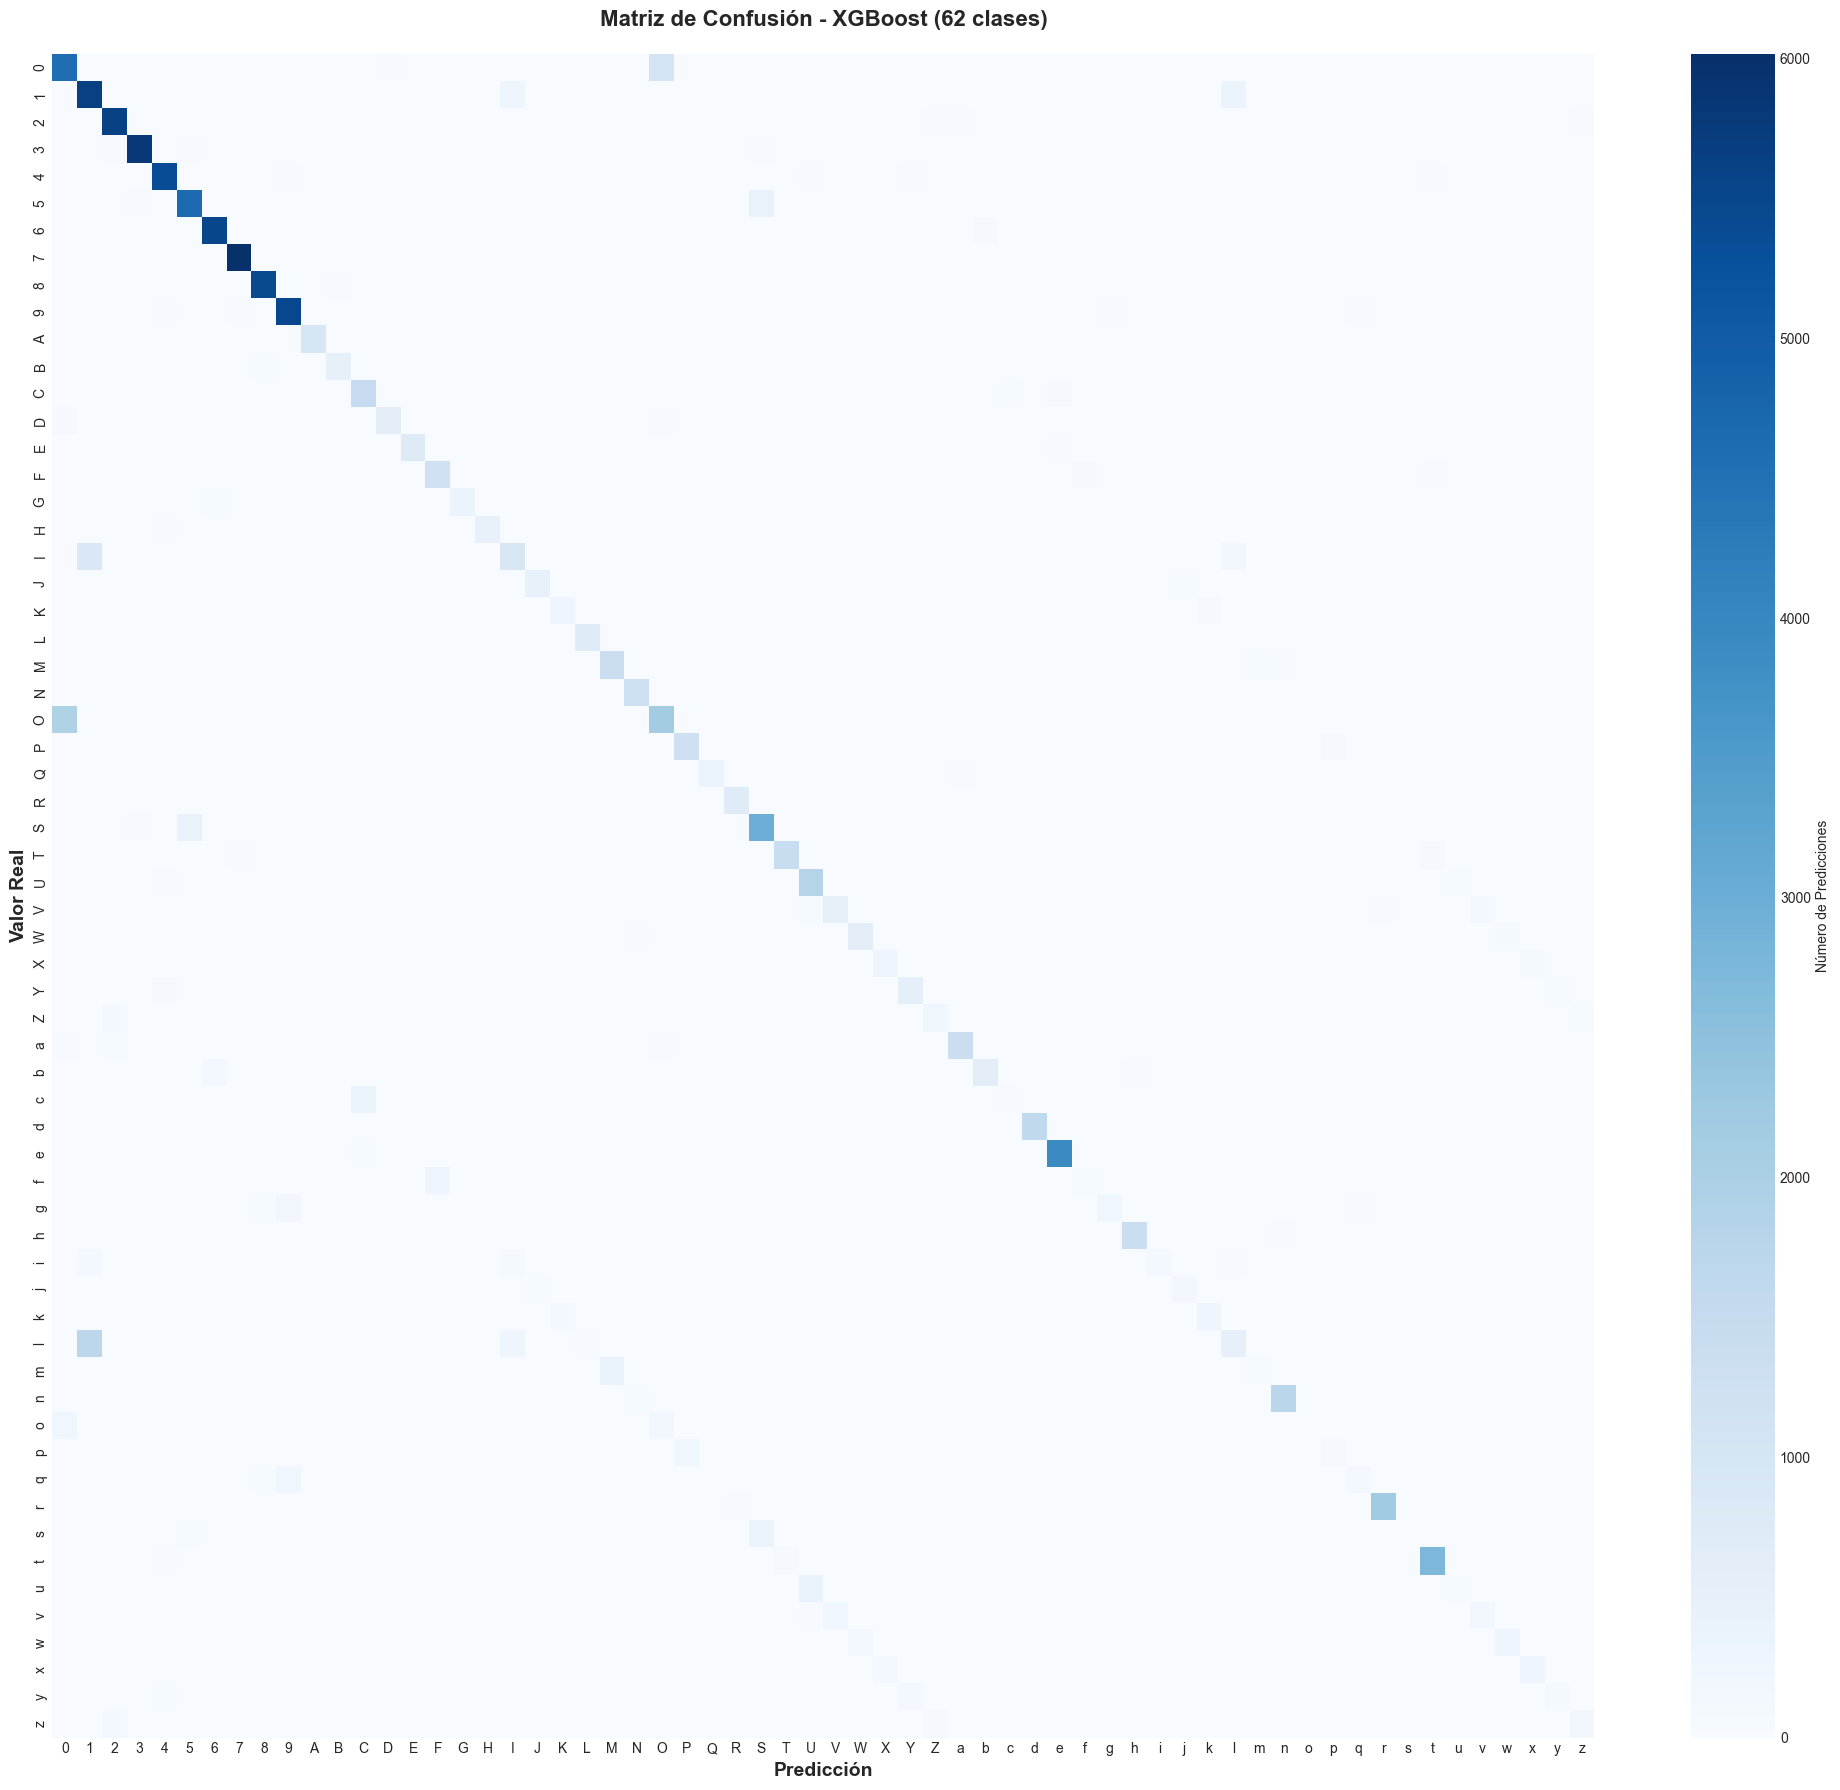

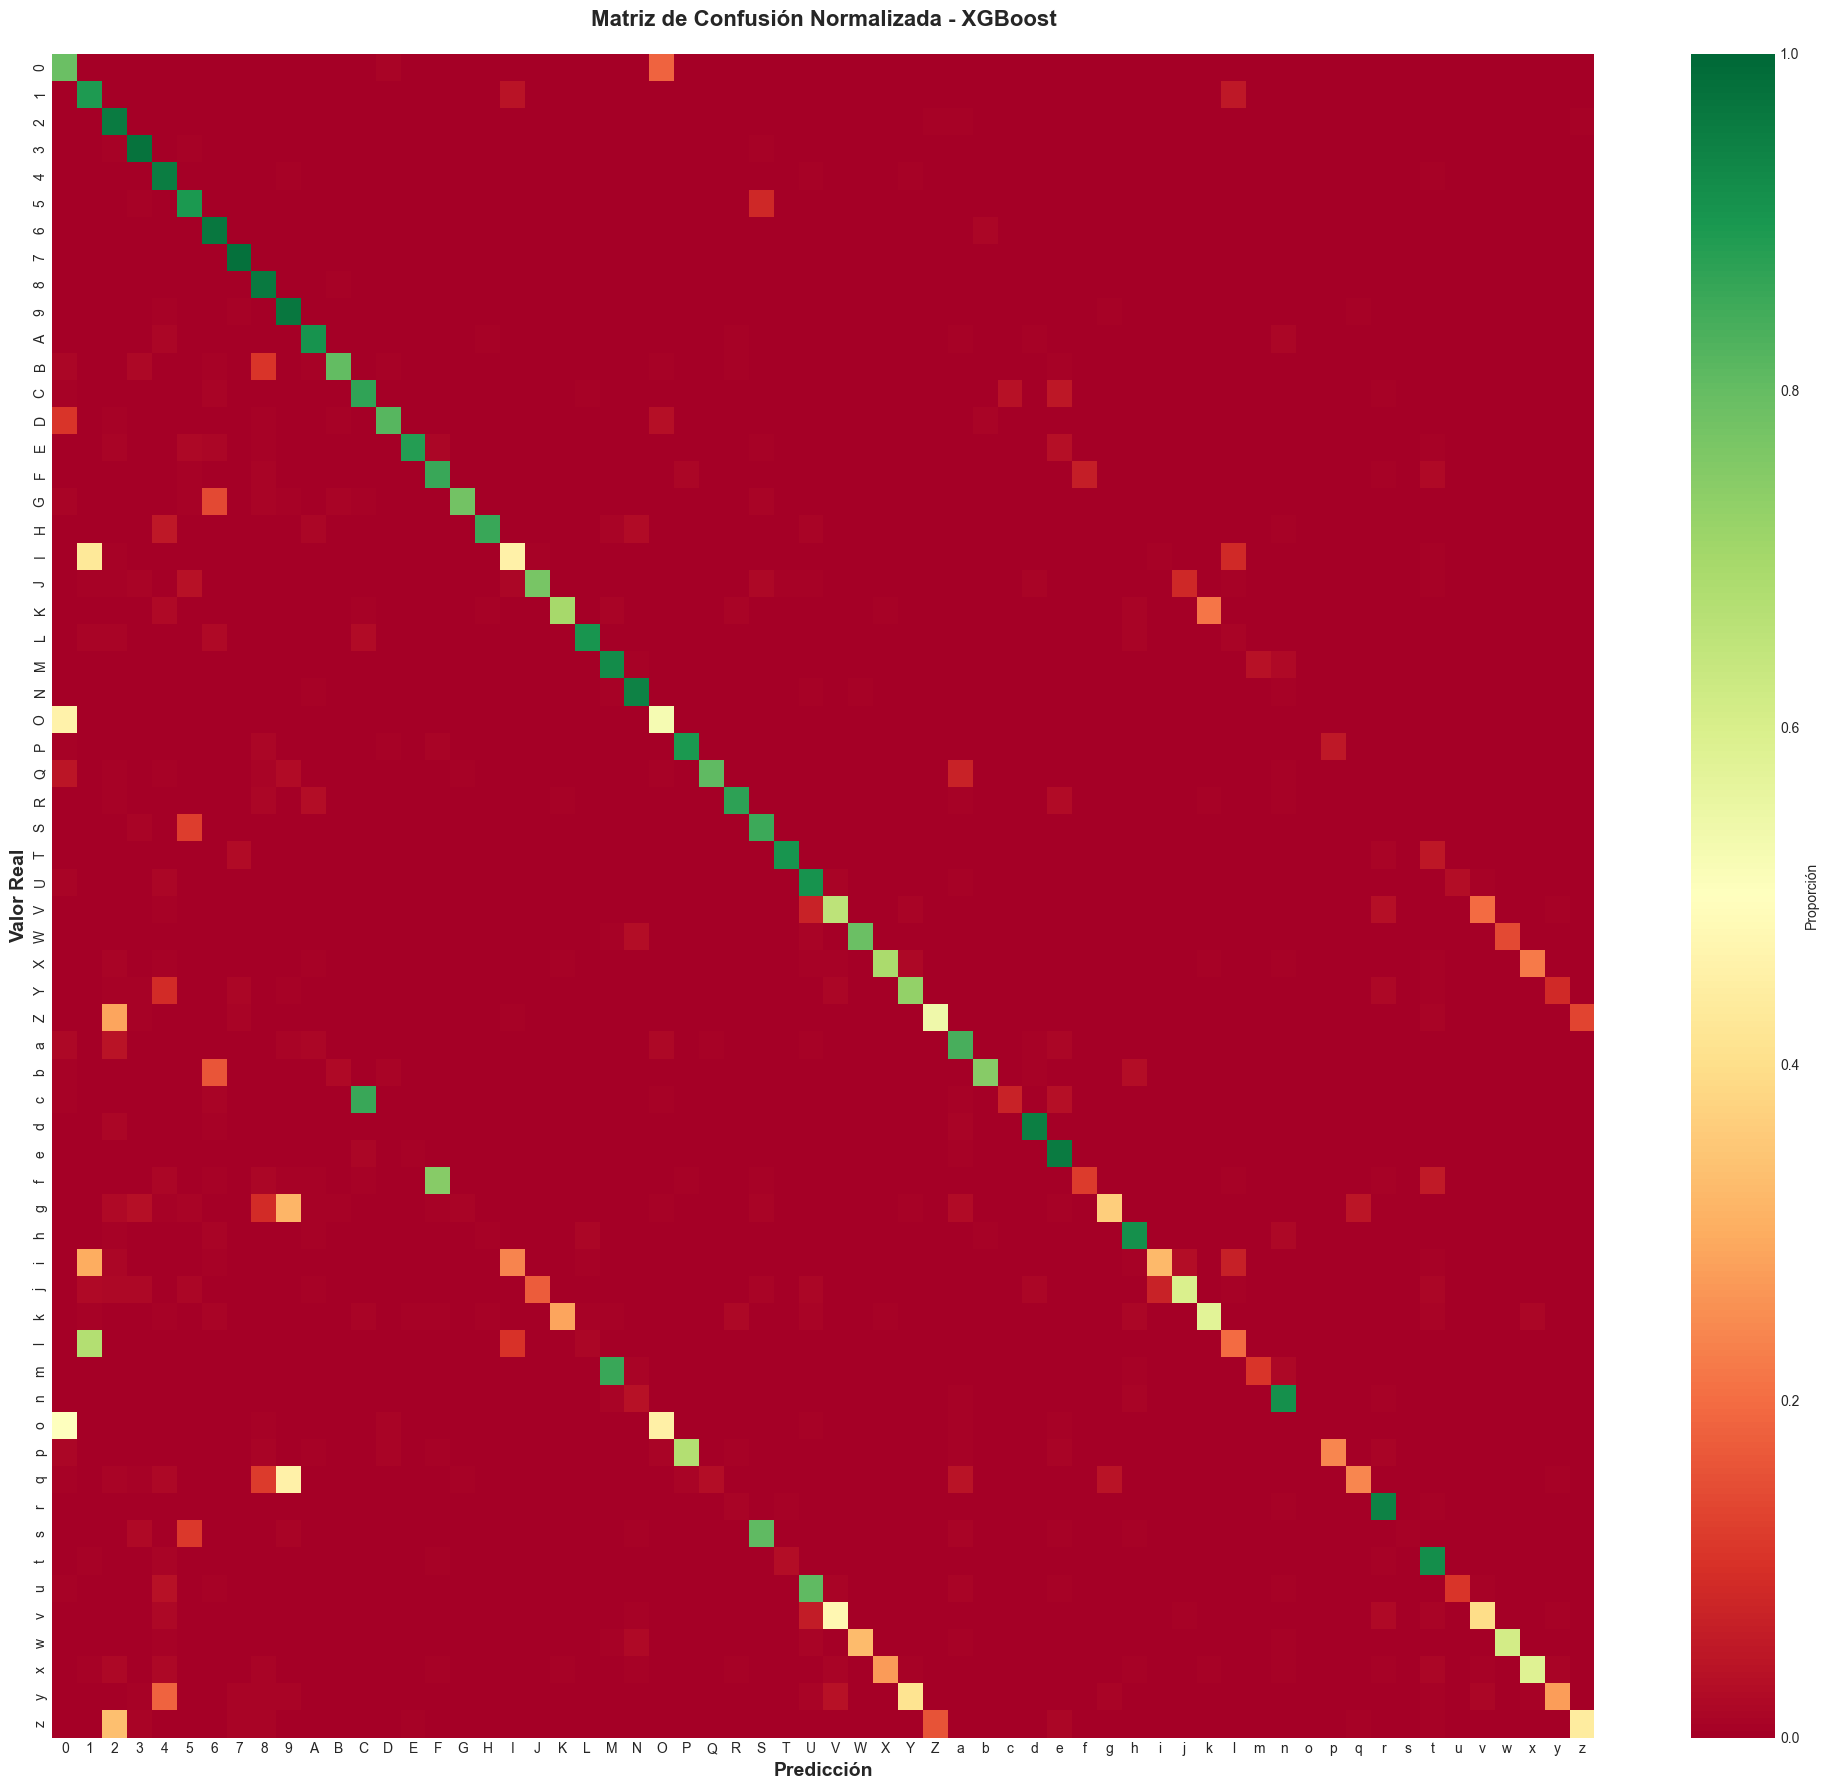

In [11]:
# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

# Visualizar matriz de confusión completa (versión reducida para legibilidad)
plt.figure(figsize=(20, 18))
sns.heatmap(
    cm, 
    annot=False, 
    fmt='d', 
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    cbar_kws={'label': 'Número de Predicciones'}
)
plt.xlabel('Predicción', fontsize=14, weight='bold')
plt.ylabel('Valor Real', fontsize=14, weight='bold')
plt.title('Matriz de Confusión - XGBoost (62 clases)', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.show()

# Matriz de confusión normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 18))
sns.heatmap(
    cm_normalized,
    annot=False,
    fmt='.2f',
    cmap='RdYlGn',
    xticklabels=target_names,
    yticklabels=target_names,
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Proporción'}
)
plt.xlabel('Predicción', fontsize=14, weight='bold')
plt.ylabel('Valor Real', fontsize=14, weight='bold')
plt.title('Matriz de Confusión Normalizada - XGBoost', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.show()

### 4.5 Análisis de Errores

TOP 20 CONFUSIONES MÁS FRECUENTES

Real Predicho  Cantidad Proporción
   O        0      1915     46.08%
   l        1      1706     67.30%
   0        O      1066     18.45%
   I        1       876     42.77%
   5        S       439      8.46%
   S        5       426     12.14%
   m        M       397     85.56%
   u        U       388     80.50%
   c        C       370     85.65%
   s        S       352     80.55%
   1        l       337      5.32%
   f        F       299     74.75%
   1        I       264      4.17%
   l        I       262     10.34%
   p        P       248     67.39%
   o        0       234     50.21%
   q        9       229     45.35%
   v        V       222     47.44%
   o        O       211     45.28%
   g        9       186     31.58%


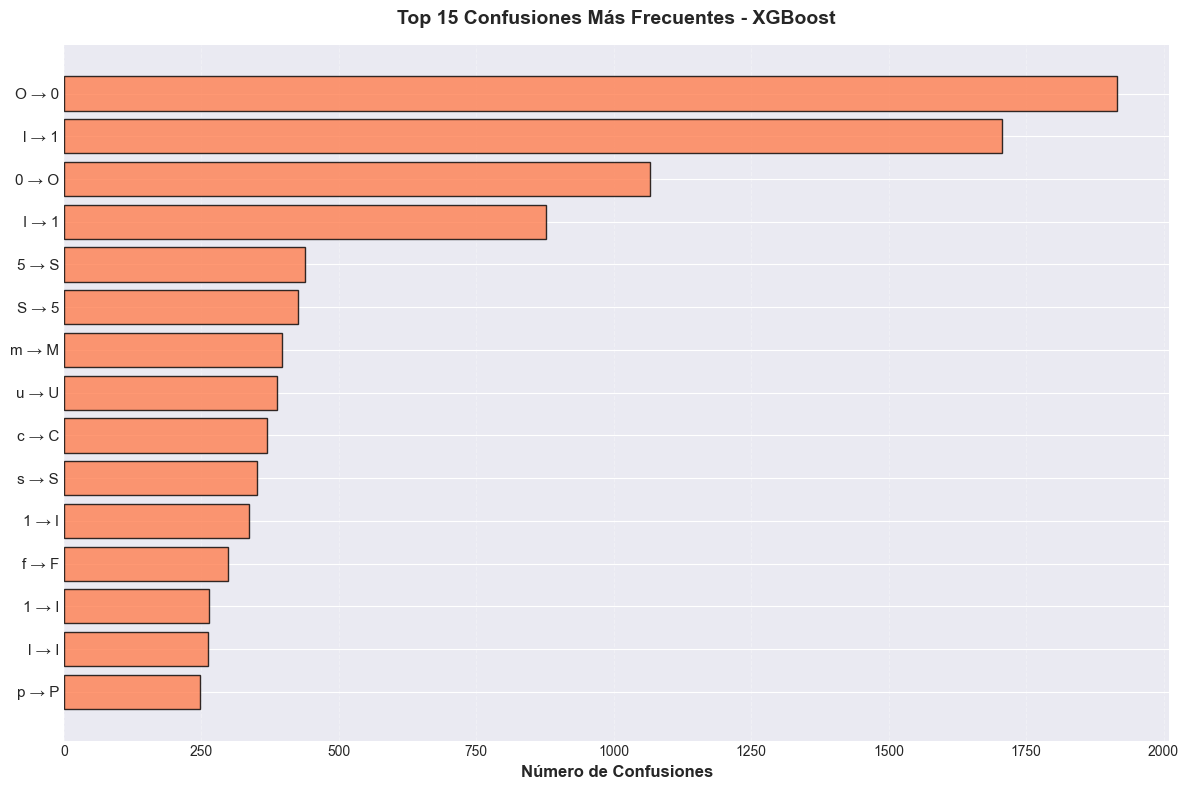


PATRONES COMUNES DE ERROR - XGBOOST
Confusiones típicas en clasificación de caracteres:
  • Caracteres visualmente similares (O/0, I/l/1, S/5, Z/2)
  • Mayúsculas vs minúsculas de formas similares
  • Caracteres con trazos curvos vs rectos
  • Simetrías y rotaciones


In [12]:
# Encontrar confusiones más frecuentes
confusion_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and cm[i, j] > 10:  # Solo confusiones significativas
            confusion_pairs.append({
                'Real': target_names[i],
                'Predicho': target_names[j],
                'Cantidad': cm[i, j],
                'Proporción': f"{cm_normalized[i, j]:.2%}"
            })

confusion_df = pd.DataFrame(confusion_pairs).sort_values('Cantidad', ascending=False)

print(f'{"="*80}')
print('TOP 20 CONFUSIONES MÁS FRECUENTES')
print(f'{"="*80}\n')
print(confusion_df.head(20).to_string(index=False))

# Visualizar top confusiones
plt.figure(figsize=(12, 8))
top_confusions = confusion_df.head(15)
labels = [f"{row['Real']} → {row['Predicho']}" for _, row in top_confusions.iterrows()]
values = top_confusions['Cantidad'].values

plt.barh(range(len(labels)), values, color='coral', alpha=0.8, edgecolor='black')
plt.yticks(range(len(labels)), labels, fontsize=11)
plt.xlabel('Número de Confusiones', fontsize=12, weight='bold')
plt.title('Top 15 Confusiones Más Frecuentes - XGBoost', fontsize=14, weight='bold', pad=15)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Análisis de patrones de error
print(f'\n{"="*80}')
print('PATRONES COMUNES DE ERROR - XGBOOST')
print(f'{"="*80}')
print('Confusiones típicas en clasificación de caracteres:')
print('  • Caracteres visualmente similares (O/0, I/l/1, S/5, Z/2)')
print('  • Mayúsculas vs minúsculas de formas similares')
print('  • Caracteres con trazos curvos vs rectos')
print('  • Simetrías y rotaciones')
print(f'{"="*80}')

### 4.6 Importancia de Features

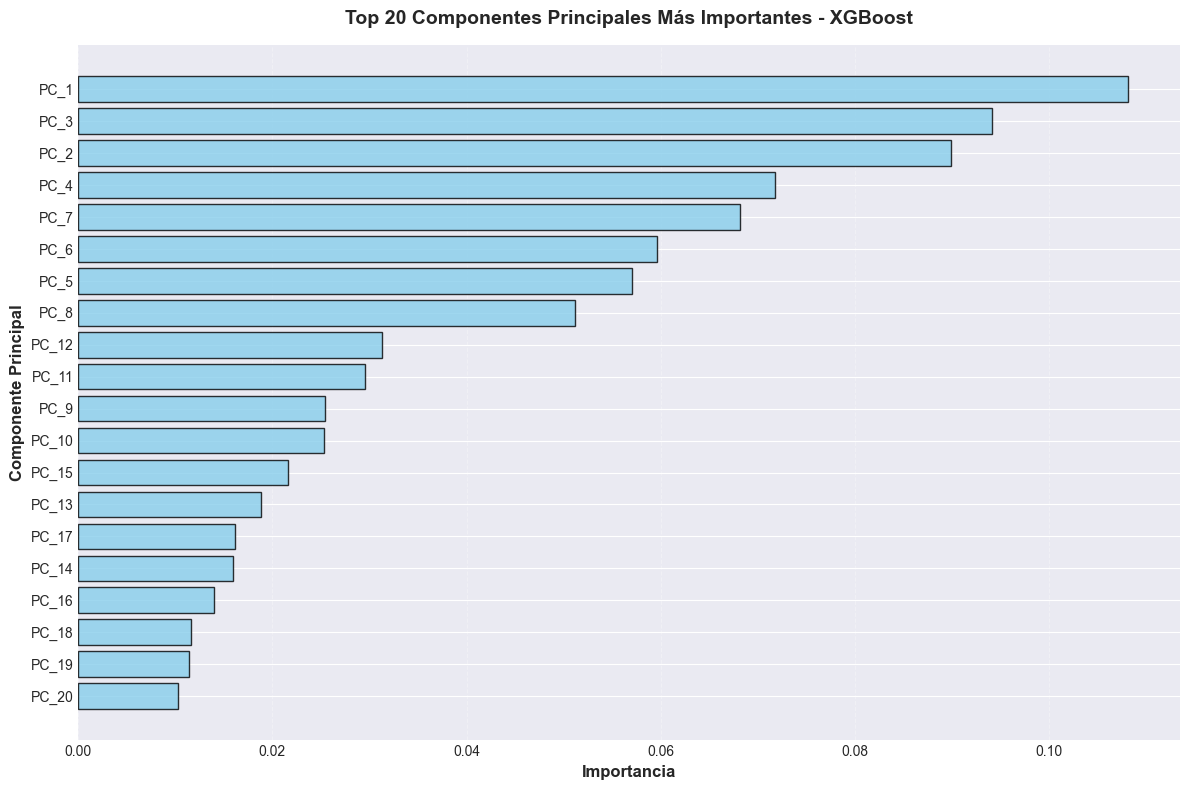

ANÁLISIS DE IMPORTANCIA DE FEATURES
Total de features: 61
Features con importancia > 0: 61
Importancia máxima: 0.1081
Importancia mínima: 0.0026
Importancia promedio: 0.0164
Top 5 componentes más importantes:
  PC_1: 0.1081
  PC_3: 0.0941
  PC_2: 0.0899
  PC_4: 0.0718
  PC_7: 0.0681


In [13]:
# Obtener importancia de features
feature_importance = model.feature_importances_

# Crear DataFrame para visualización
importance_df = pd.DataFrame({
    'feature': [f'PC_{i+1}' for i in range(len(feature_importance))],
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Visualizar top 20 features más importantes
plt.figure(figsize=(12, 8))
plt.barh(importance_df['feature'].head(20)[::-1], 
         importance_df['importance'].head(20)[::-1],
         color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel('Importancia', fontsize=12, weight='bold')
plt.ylabel('Componente Principal', fontsize=12, weight='bold')
plt.title('Top 20 Componentes Principales Más Importantes - XGBoost', 
          fontsize=14, weight='bold', pad=15)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Estadísticas de importancia
print(f'{"="*60}')
print('ANÁLISIS DE IMPORTANCIA DE FEATURES')
print(f'{"="*60}')
print(f'Total de features: {len(feature_importance)}')
print(f'Features con importancia > 0: {(feature_importance > 0).sum()}')
print(f'Importancia máxima: {feature_importance.max():.4f}')
print(f'Importancia mínima: {feature_importance.min():.4f}')
print(f'Importancia promedio: {feature_importance.mean():.4f}')
print(f'Top 5 componentes más importantes:')
for i, row in importance_df.head().iterrows():
    print(f'  {row["feature"]}: {row["importance"]:.4f}')
print(f'{"="*60}')

### 4.7 Distribución de Confianza

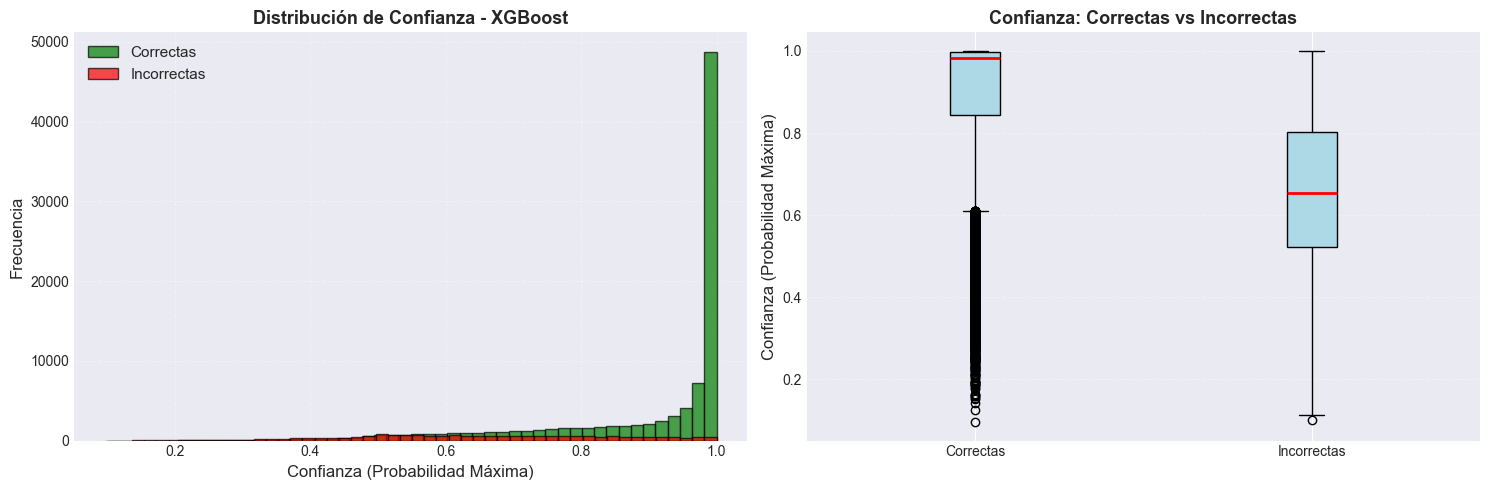

ESTADÍSTICAS DE CONFIANZA - XGBOOST

Predicciones Correctas:
  Media:    0.8986
  Mediana:  0.9824
  Std:      0.1504
  Min:      0.0961
  Max:      1.0000

Predicciones Incorrectas:
  Media:    0.6601
  Mediana:  0.6539
  Std:      0.1825
  Min:      0.1003
  Max:      0.9999

Análisis de confianza alta (> 0.8):
  Correctas con alta confianza: 79.04%
  Incorrectas con alta confianza: 25.45%


In [14]:
# Obtener probabilidades de predicción
y_test_proba = model.predict_proba(X_test)
max_probas = np.max(y_test_proba, axis=1)

# Separar por predicciones correctas e incorrectas
correct_mask = y_test == y_test_pred
correct_probas = max_probas[correct_mask]
incorrect_probas = max_probas[~correct_mask]

# Visualizar distribución
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Histograma general
ax1.hist(correct_probas, bins=50, alpha=0.7, label='Correctas', color='green', edgecolor='black')
ax1.hist(incorrect_probas, bins=50, alpha=0.7, label='Incorrectas', color='red', edgecolor='black')
ax1.set_xlabel('Confianza (Probabilidad Máxima)', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_title('Distribución de Confianza - XGBoost', fontsize=13, weight='bold')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3, linestyle='--')

# Box plot comparativo
ax2.boxplot(
    [correct_probas, incorrect_probas],
    labels=['Correctas', 'Incorrectas'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', edgecolor='black'),
    medianprops=dict(color='red', linewidth=2)
)
ax2.set_ylabel('Confianza (Probabilidad Máxima)', fontsize=12)
ax2.set_title('Confianza: Correctas vs Incorrectas', fontsize=13, weight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# Estadísticas de confianza
print(f'{"="*60}')
print('ESTADÍSTICAS DE CONFIANZA - XGBOOST')
print(f'{"="*60}')
print(f'\nPredicciones Correctas:')
print(f'  Media:    {correct_probas.mean():.4f}')
print(f'  Mediana:  {np.median(correct_probas):.4f}')
print(f'  Std:      {correct_probas.std():.4f}')
print(f'  Min:      {correct_probas.min():.4f}')
print(f'  Max:      {correct_probas.max():.4f}')

print(f'\nPredicciones Incorrectas:')
print(f'  Media:    {incorrect_probas.mean():.4f}')
print(f'  Mediana:  {np.median(incorrect_probas):.4f}')
print(f'  Std:      {incorrect_probas.std():.4f}')
print(f'  Min:      {incorrect_probas.min():.4f}')
print(f'  Max:      {incorrect_probas.max():.4f}')

# Análisis de umbral de confianza
high_confidence_threshold = 0.8
high_conf_correct = (correct_probas > high_confidence_threshold).mean()
high_conf_incorrect = (incorrect_probas > high_confidence_threshold).mean()

print(f'\nAnálisis de confianza alta (> {high_confidence_threshold}):')
print(f'  Correctas con alta confianza: {high_conf_correct:.2%}')
print(f'  Incorrectas con alta confianza: {high_conf_incorrect:.2%}')
print(f'{"="*60}')

## 5. Guardar Modelo y Resultados (pkl)

In [15]:
# Crear directorio de salida
output_dir = Path('output')
output_dir.mkdir(exist_ok=True)

print(f'{"="*60}')
print('GUARDANDO MODELO Y RESULTADOS')
print(f'{"="*60}\n')

# Guardar modelo
model_path = output_dir / 'xgboost_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f'✓ Modelo XGBoost guardado: {model_path}')

# Guardar mapeo de clases
mapping_path = output_dir / 'class_mapping.pkl'
with open(mapping_path, 'wb') as f:
    pickle.dump(class_mapping, f)
print(f'✓ Mapeo de clases guardado: {mapping_path}')

# Guardar métricas
metrics = {
    'train_accuracy': float(train_accuracy),
    'train_precision': float(train_precision),
    'train_recall': float(train_recall),
    'train_f1': float(train_f1),
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'training_time': float(training_time),
    'n_components': X_train.shape[1],
    'n_classes': int(len(model.classes_)),
    'n_samples_train': int(len(y_train)),
    'n_samples_test': int(len(y_test)),
    'feature_importance': feature_importance.tolist()
}

metrics_path = output_dir / 'xgboost_metrics.pkl'
with open(metrics_path, 'wb') as f:
    pickle.dump(metrics, f)
print(f'✓ Métricas guardadas: {metrics_path}')

# Guardar importancia de features
importance_path = output_dir / 'feature_importance.pkl'
with open(importance_path, 'wb') as f:
    pickle.dump(importance_df.to_dict(), f)
print(f'✓ Importancia de features guardada: {importance_path}')

print(f'\n{"="*60}')
print('✓ TODOS LOS ARCHIVOS GUARDADOS EXITOSAMENTE')
print(f'{"="*60}')
print('\nArchivos generados:')
print('  1. xgboost_model.pkl - Modelo entrenado')
print('  2. class_mapping.pkl - Mapeo de clases')
print('  3. xgboost_metrics.pkl - Métricas de evaluación')
print('  4. feature_importance.pkl - Importancia de features')
print('\n✓ Listos para usar en análisis comparativo y SHAP')
print(f'{"="*60}')

GUARDANDO MODELO Y RESULTADOS

✓ Modelo XGBoost guardado: output\xgboost_model.pkl
✓ Mapeo de clases guardado: output\class_mapping.pkl
✓ Métricas guardadas: output\xgboost_metrics.pkl
✓ Importancia de features guardada: output\feature_importance.pkl

✓ TODOS LOS ARCHIVOS GUARDADOS EXITOSAMENTE

Archivos generados:
  1. xgboost_model.pkl - Modelo entrenado
  2. class_mapping.pkl - Mapeo de clases
  3. xgboost_metrics.pkl - Métricas de evaluación
  4. feature_importance.pkl - Importancia de features

✓ Listos para usar en análisis comparativo y SHAP


## 6. Resumen Final y Comparación

In [16]:
print(f'{"="*80}')
print('RESUMEN FINAL - XGBOOST PARA CLASIFICACIÓN DE CARACTERES')
print(f'{"="*80}')

print(f'\n{"CONFIGURACIÓN DEL MODELO":^80}')
print(f'{"-"*80}')
print(f'  Algoritmo:              XGBoost (Gradient Boosting)')
print(f'  Objetivo:               multi:softprob')
print(f'  Número de árboles:      {model.n_estimators}')
print(f'  Profundidad máxima:     6')
print(f'  Tasa de aprendizaje:    0.1')
print(f'  Submuestreo:            0.8')
print(f'  Submuestreo columnas:   0.8')
print(f'  Regularización L2:      1.0')

print(f'\n{"DATASET":^80}')
print(f'{"-"*80}')
print(f'  Train:                  {len(y_train):,} muestras')
print(f'  Test:                   {len(y_test):,} muestras')
print(f'  Features (PCA):         {X_train.shape[1]} componentes')
print(f'  Clases:                 {len(model.classes_)} caracteres')

print(f'\n{"RENDIMIENTO (TEST SET)":^80}')
print(f'{"-"*80}')
print(f'  Accuracy:               {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')
print(f'  Precision:              {test_precision:.4f}')
print(f'  Recall:                 {test_recall:.4f}')
print(f'  F1-Score:               {test_f1:.4f}')
print(f'  Tiempo entrenamiento:   {training_time:.2f}s ({training_time/60:.2f} min)')

print(f'\n{"ANÁLISIS DE ROBUSTEZ":^80}')
print(f'{"-"*80}')
print(f'  Diferencia train-test:  {diff_accuracy:.4f} ({diff_accuracy*100:.2f}%)')
print(f'  Confianza media:        {correct_probas.mean():.4f}')
print(f'  Features importantes:   {(feature_importance > 0).sum()}/{len(feature_importance)}')

print(f'\n{"VENTAJAS DEL MODELO":^80}')
print(f'{"-"*80}')
print('  ✓ Alto rendimiento en problemas complejos')
print('  ✓ Captura relaciones no lineales entre features')
print('  ✓ Robustez ante overfitting (regularización)')
print('  ✓ Importancia de features interpretable')
print('  ✓ Manejo automático de missing values')
print('  ✓ Eficiente con grandes volúmenes de datos')

print(f'\n{"APLICACIÓN EN PROYECTO":^80}')
print(f'{"-"*80}')
print('  → Clasificación robusta de caracteres escritos a mano')
print('  → Base para análisis SHAP de interpretabilidad')
print('  → Comparación con modelos lineales (Regresión Logística)')
print('  → Potencial mejora con tuning de hiperparámetros')

print(f'\n{"="*80}')
print('✓ MODELO XGBOOST ENTRENADO Y EVALUADO EXITOSAMENTE')
print(f'{"="*80}')
print('\nPróximos pasos recomendados:')
print('  → Realizar análisis SHAP para interpretabilidad')
print('  → Comparar con Random Forest y Regresión Logística')
print('  → Optimizar hiperparámetros con GridSearch/RandomSearch')
print('  → Integrar en pipeline de producción')
print(f'\n{"="*80}')

RESUMEN FINAL - XGBOOST PARA CLASIFICACIÓN DE CARACTERES

                            CONFIGURACIÓN DEL MODELO                            
--------------------------------------------------------------------------------
  Algoritmo:              XGBoost (Gradient Boosting)
  Objetivo:               multi:softprob
  Número de árboles:      500
  Profundidad máxima:     6
  Tasa de aprendizaje:    0.1
  Submuestreo:            0.8
  Submuestreo columnas:   0.8
  Regularización L2:      1.0

                                    DATASET                                     
--------------------------------------------------------------------------------
  Train:                  697,932 muestras
  Test:                   116,323 muestras
  Features (PCA):         61 componentes
  Clases:                 62 caracteres

                             RENDIMIENTO (TEST SET)                             
--------------------------------------------------------------------------------
  Accuracy:   

## 9. Ejemplo Práctico: Clasificación de un Input Manual

Ahora veremos un ejemplo de cómo usar el modelo entrenado para clasificar un carácter sin usar la interfaz gráfica. Este ejemplo muestra exactamente cómo se procesaría un input y cómo obtener la predicción.

EJEMPLO DE CLASIFICACIÓN CON XGBOOST

📌 Muestra seleccionada: Índice 35609
📌 Etiqueta real: 5 (Carácter: '5')
📌 Shape de features: (1, 61)


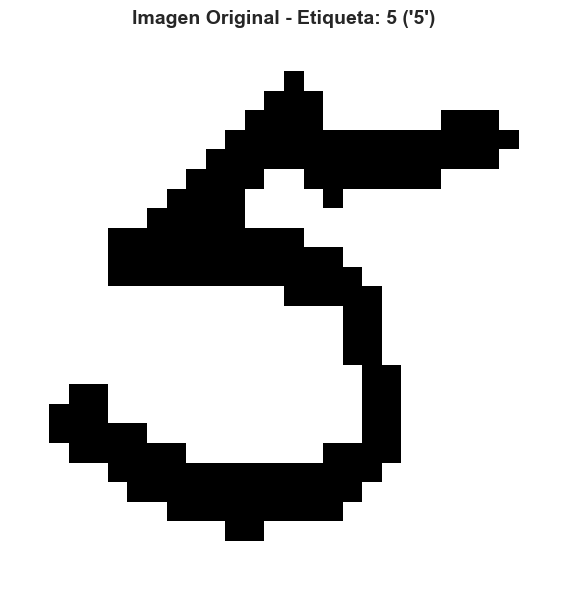


------------------------------------------------------------

🔮 PREDICCIÓN DEL MODELO:
   Clase predicha: 5
   Carácter predicho: '5'
   Confianza: 98.93%

📊 TOP 5 PREDICCIONES:
    Carácter    Probabilidad   Barra
------------------------------------------------------------
✓  1. '5'          98.93%        █████████████████████████████████████████████████
   2. 'S'           1.01%        
   3. 's'           0.04%        
   4. 'g'           0.00%        
   5. '3'           0.00%        

------------------------------------------------------------

✅ PREDICCIÓN CORRECTA


In [26]:
# Tomemos un ejemplo aleatorio del conjunto de test
import random

# Seleccionar un índice aleatorio
random_idx = random.randint(0, len(X_test) - 1)

# Obtener la muestra y su etiqueta real
sample_features = X_test[random_idx:random_idx+1]  # Mantener forma 2D (1, 61)
true_label = y_test[random_idx]
true_char = class_mapping[true_label]

print(f"{'='*60}")
print(f"EJEMPLO DE CLASIFICACIÓN CON XGBOOST")
print(f"{'='*60}\n")

print(f"📌 Muestra seleccionada: Índice {random_idx}")
print(f"📌 Etiqueta real: {true_label} (Carácter: '{true_char}')")
print(f"📌 Shape de features: {sample_features.shape}")

# Cargar la imagen original desde el archivo preprocesado
test_data_original = np.load('../../preprocesamiento/output/emnist_test_processed.npz')
X_test_images = test_data_original['X_test']
original_image = X_test_images[random_idx]

# Mostrar la imagen original
plt.figure(figsize=(6, 6))
plt.imshow(original_image, cmap='gray')
plt.title(f"Imagen Original - Etiqueta: {true_label} ('{true_char}')", fontsize=14, weight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\n{'-'*60}\n")

# Realizar la predicción
prediction = model.predict(sample_features)[0]
predicted_char = class_mapping[prediction]

# Obtener las probabilidades
probabilities = model.predict_proba(sample_features)[0]
confidence = probabilities[prediction] * 100

print(f"🔮 PREDICCIÓN DEL MODELO:")
print(f"   Clase predicha: {prediction}")
print(f"   Carácter predicho: '{predicted_char}'")
print(f"   Confianza: {confidence:.2f}%\n")

# Mostrar top 5 predicciones
top5_indices = np.argsort(probabilities)[-5:][::-1]
print(f"📊 TOP 5 PREDICCIONES:")
print(f"    Carácter    Probabilidad   Barra")
print(f"{'-'*60}")

for i, idx in enumerate(top5_indices, 1):
    char = class_mapping[idx]
    prob = probabilities[idx] * 100
    bar_length = int(prob / 2)  # Escala para visualización
    bar = '█' * bar_length
    marker = '✓' if idx == true_label else ' '
    print(f"{marker:2} {i}. {char!r:<12}{prob:6.2f}%        {bar}")

print(f"\n{'-'*60}\n")

# Verificar si la predicción es correcta
if prediction == true_label:
    print("✅ PREDICCIÓN CORRECTA")
else:
    print(f"❌ PREDICCIÓN INCORRECTA")
    print(f"   El modelo predijo '{predicted_char}' pero era '{true_char}'")